# Categorical encodings

In [42]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random

In [43]:
import matplotlib.pyplot as plt

In [44]:
PATH = Path("/Users/yannetinterian/teaching/deep-learning-di/data")

In [47]:
# Label encoding is simply converting each value in a column to a number (0 to num_classes).
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Car (toy) dataset 
https://archive.ics.uci.edu/ml/datasets/Car+Evaluation

In [69]:
data = pd.read_csv(PATH/"cars/car.data", header=None)
data.head()

,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [70]:
Y = data.iloc[:, 6].values
Y

array(['unacc', 'unacc', 'unacc', ..., 'unacc', 'good', 'vgood'],
      dtype=object)

In [71]:
data.columns

Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')

In [72]:
X = data.drop([6], axis=1)

In [73]:
X.head()

,0,1,2,3,4,5
0,vhigh,vhigh,2,2,small,low
1,vhigh,vhigh,2,2,small,med
2,vhigh,vhigh,2,2,small,high
3,vhigh,vhigh,2,2,med,low
4,vhigh,vhigh,2,2,med,med


In [118]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.20, random_state=3)
X_train.head()

,0,1,2,3,4,5
1223,med,low,3,2,big,high
1517,low,med,2,2,med,high
126,vhigh,high,2,more,small,low
1715,low,low,5more,4,med,high
58,vhigh,vhigh,4,2,med,med


In [119]:
X_train.dtypes

0    object
1    object
2    object
3    object
4    object
5    object
dtype: object

In [120]:
for col in X_train.columns:
    if X_train.dtypes[col] == "object":
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col])
        X_val[col] = le.transform(X_val[col])

/Users/yannetinterian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/yannetinterian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [121]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

In [122]:
y_train

array([2, 2, 2, ..., 1, 2, 3])

In [123]:
X_train.head()

,0,1,2,3,4,5
1223,2,1,1,0,0,0
1517,1,2,0,0,1,0
126,3,0,0,2,2,1
1715,1,1,3,1,1,0
58,3,3,2,0,1,2


In [124]:
X_val.head()

,0,1,2,3,4,5
350,3,1,0,2,0,0
112,3,0,0,0,1,2
1011,2,0,1,1,1,1
715,0,2,2,1,1,2
1280,2,1,3,1,2,0


In [125]:
X_train.shape

(1382, 6)

In [126]:
[np.unique(X_train[col].values) for col in X_train]

[array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2])]

In [127]:
cat_levels = [len(np.unique(X_train[col].values)) for col in X_train]
cat_levels 

[4, 4, 4, 3, 3, 3]

## Embedding layer
Most deep learning models use a dense vectors of real numbers as representation of words or categorical variables, as opposed to a one-hot encoding representations. The module torch.nn.Embedding is used to represent word embeddings. It takes two arguments: number of levels in your categorical variable, and the dimensionality of the embeddings. The embeddings are initialized with random vectors and are learned in the training process.

In [175]:
# An Embedding layer containing 4 categories and embedding size 5. 
# Embeddings will be initialized at random.
embed = nn.Embedding(4, 5)
embed.weight

Parameter containing:
tensor([[-0.2362, -1.1640,  1.4995, -0.1408,  0.9529],
        [-1.5915,  0.3404, -2.1976, -0.1452,  0.7634],
        [-0.7736, -1.2214, -1.9864, -0.1815, -0.4461],
        [ 0.3987,  1.2341,  0.3971,  0.2056,  0.5141]], requires_grad=True)

In [177]:
# Each categotical variable with K levels should be relabel with levels between 0 and K-1.
# Given a coulmn x, to "look up" the embedding of each level do:
# Note that it needs type LongTensor
x = torch.LongTensor([1, 0, 1, 3, 3 , 2])
embed(x)

tensor([[-1.5915,  0.3404, -2.1976, -0.1452,  0.7634],
        [-0.2362, -1.1640,  1.4995, -0.1408,  0.9529],
        [-1.5915,  0.3404, -2.1976, -0.1452,  0.7634],
        [ 0.3987,  1.2341,  0.3971,  0.2056,  0.5141],
        [ 0.3987,  1.2341,  0.3971,  0.2056,  0.5141],
        [-0.7736, -1.2214, -1.9864, -0.1815, -0.4461]],
       grad_fn=<EmbeddingBackward>)

## Model

In [163]:
class TabularModel(nn.Module):
    def __init__(self, cat_levels, emb_size=5, n_class=4):
        super().__init__()
        self.embs = nn.ModuleList([nn.Embedding(c, emb_size) for c in cat_levels])
        self.lin1 = nn.Linear(6*emb_size, 20)
        self.lin2 = nn.Linear(20, n_class)
        self.bn = nn.BatchNorm1d(20)
        self.emb_drop = nn.Dropout(0.1)
        self.drops = nn.Dropout(0.1)

    def forward(self, x):
        # try to write a shorter code
        e0 = self.embs[0](x[:,0])
        e1 = self.embs[1](x[:,1])
        e2 = self.embs[2](x[:,2])
        e3 = self.embs[3](x[:,3])
        e4 = self.embs[4](x[:,4])
        e5 = self.embs[5](x[:,5])
        x = torch.cat([e0, e1, e2, e3, e4, e5], 1)
        x = self.emb_drop(x)
        x = F.relu(self.lin1(x))
        x = self.drops(x)
        x = self.bn(x)
        x = self.lin2(x)
        return x

In [164]:
model = TabularModel(cat_levels)

In [165]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    return optim

In [166]:
x_train = torch.LongTensor(X_train.values)
y_train = torch.LongTensor(y_train)

In [172]:
def train_model(model, optim, epochs=5):
    for i in range(epochs):
        model.train()
        out = model(x_train)
        loss = F.cross_entropy(out, y_train)   
        optim.zero_grad()
        loss.backward()
        optim.step()
        val_loss, val_acc = val_metric(model)
        if i % 15 == 0: 
            print("train loss %.3f val loss %.3f and accuracy %.3f" % (loss, val_loss, val_acc))

In [168]:
x_val = torch.LongTensor(X_val.values)
y_val = torch.LongTensor(y_val)

In [169]:
def val_metric(model):
    model.eval()
    correct = 0
    out = model(x_val)
    loss = F.cross_entropy(out, y_val)
    pred = torch.max(out, 1)[1]
    correct += (pred == y_val).float().sum().item()
    return loss, correct/y_val.shape[0]

In [173]:
model = TabularModel(cat_levels)
optim = get_optimizer(model, lr = 0.01, wd = 0.0)

In [174]:
train_model(model, optim, epochs=150)

train loss 1.495 val loss 1.380 and accuracy 0.344
train loss 0.625 val loss 0.581 and accuracy 0.824
train loss 0.288 val loss 0.253 and accuracy 0.910
train loss 0.210 val loss 0.165 and accuracy 0.948
train loss 0.183 val loss 0.118 and accuracy 0.971
train loss 0.131 val loss 0.099 and accuracy 0.980
train loss 0.131 val loss 0.091 and accuracy 0.977
train loss 0.127 val loss 0.074 and accuracy 0.977
train loss 0.105 val loss 0.077 and accuracy 0.974
train loss 0.113 val loss 0.065 and accuracy 0.980


# WiDS 2018  dataset

The data for this part of the notebook comes from this kaggle [competition](https://www.kaggle.com/c/wids2018datathon/). You are given a dataset of survey questions and results from a developing country. Your goal is to predict the gender of the respondent based on the other answers he/she provided. You Kaggle api to get the data. All variables in this dataset and categorical.

`pip install kaggle` <br/>

`kaggle competitions download -c wids2018datathon -p /path/to/data`

In [183]:
train = pd.read_csv(PATH/"train.csv", low_memory=False)
train.head()

,train_id,AA3,AA4,AA5,AA6,AA7,AA14,AA15,DG1,is_female,...,GN1,GN1_OTHERS,GN2,GN2_OTHERS,GN3,GN3_OTHERS,GN4,GN4_OTHERS,GN5,GN5_OTHERS
0,0,3,32,3.0,NaN,323011,3854,481,1975,1,...,99.0,NaN,99,NaN,99,NaN,99,NaN,99,NaN
1,1,2,26,NaN,8.0,268131,2441,344,1981,1,...,NaN,NaN,1,NaN,2,NaN,2,NaN,2,NaN
2,2,1,16,NaN,7.0,167581,754,143,1995,1,...,1.0,NaN,2,NaN,2,NaN,2,NaN,2,NaN
3,3,4,44,5.0,NaN,445071,5705,604,1980,1,...,NaN,NaN,2,NaN,2,NaN,99,NaN,99,NaN
4,4,4,43,NaN,6.0,436161,5645,592,1958,1,...,NaN,NaN,1,NaN,1,NaN,1,NaN,1,NaN


In [184]:
train.shape

(18255, 1235)

In [185]:
# train id looks like a unique id for each row
train = train.drop(columns=["train_id"])
train.head()

,AA3,AA4,AA5,AA6,AA7,AA14,AA15,DG1,is_female,DG3,...,GN1,GN1_OTHERS,GN2,GN2_OTHERS,GN3,GN3_OTHERS,GN4,GN4_OTHERS,GN5,GN5_OTHERS
0,3,32,3.0,NaN,323011,3854,481,1975,1,3,...,99.0,NaN,99,NaN,99,NaN,99,NaN,99,NaN
1,2,26,NaN,8.0,268131,2441,344,1981,1,8,...,NaN,NaN,1,NaN,2,NaN,2,NaN,2,NaN
2,1,16,NaN,7.0,167581,754,143,1995,1,3,...,1.0,NaN,2,NaN,2,NaN,2,NaN,2,NaN
3,4,44,5.0,NaN,445071,5705,604,1980,1,3,...,NaN,NaN,2,NaN,2,NaN,99,NaN,99,NaN
4,4,43,NaN,6.0,436161,5645,592,1958,1,3,...,NaN,NaN,1,NaN,1,NaN,1,NaN,1,NaN


## Cleaning columns with too many NAs

In [186]:
train["AA5"].isnull().sum()

12602

In [187]:
# counting the number of NULL in per column
train.isnull().sum()

AA3                     0
AA4                     0
AA5                 12602
AA6                  5653
AA7                     0
AA14                    0
AA15                    0
DG1                     0
is_female               0
DG3                     0
DG3A                    0
DG3A_OTHERS         18205
DG4                     0
DG4_OTHERS          18255
DG5_1                   0
DG5_2                   0
DG5_3                   0
DG5_4                   0
DG5_5                   0
DG5_6                   0
DG5_7                   0
DG5_8                   0
DG5_9                   0
DG5_10                  0
DG5_11                  0
DG5_96                  0
DG6                     0
DG8a                    0
DG8b                    0
DG8c                    0
                    ...  
FB28_2_OTHERS       18253
FB28_3_OTHERS       18255
FB28_4_OTHERS       18253
FB28_96_OTHERS      18254
FB29_1                  0
FB29_2                  0
FB29_3                  0
FB29_4      

In [188]:
## dropping columns with too many nulls
for col in train.columns:
    if train[col].isnull().sum() > 12000:
        #print(col, train[col].isnull().sum())
        train.drop(col, axis=1, inplace=True)

In [189]:
# just kept 421 columns
train.head()

,AA3,AA4,AA6,AA7,AA14,AA15,DG1,is_female,DG3,DG3A,...,LN2_2,LN2_3,LN2_4,LN2_RIndLngBEOth,LN2_WIndLngBEOth,GN1,GN2,GN3,GN4,GN5
0,3,32,NaN,323011,3854,481,1975,1,3,4,...,1,1,1,NaN,NaN,99.0,99,99,99,99
1,2,26,8.0,268131,2441,344,1981,1,8,4,...,1,3,4,Bengali,Bengali,NaN,1,2,2,2
2,1,16,7.0,167581,754,143,1995,1,3,2,...,1,2,2,Hindi,Hindi,1.0,2,2,2,2
3,4,44,NaN,445071,5705,604,1980,1,3,4,...,1,4,5,Tamil,Tamil,NaN,2,2,99,99
4,4,43,6.0,436161,5645,592,1958,1,3,4,...,4,4,4,Malayalam,Malayalam,NaN,1,1,1,1


In [190]:
train.shape

(18255, 421)

In [191]:
# save to a csv
train.to_csv(PATH/"train_421_cols.csv", index=False)

## Picking columns for embeddings

In [192]:
train = pd.read_csv(PATH/"train_421_cols.csv")

In [193]:
# Saving the label into another variable, dropping from main dataframe
Y = train["is_female"].values.astype(np.float32)
X = train.drop(columns=["is_female"])

In [194]:
# filling NAs and doing label encoding
# Label encoding is simply converting each value in a column to a number (0 to num_classes).
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
for col in X.columns:
    if X.dtypes[col] == "object":
        X[col] = X[col].fillna("NA")
    else:
        X[col] = X[col].fillna(0)
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

In [195]:
# telling pandas that all the variables are categorical
for col in X.columns:
    X[col] = X[col].astype('category')

In [196]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.20, random_state=3)
X_train.head()

,AA3,AA4,AA6,AA7,AA14,AA15,DG1,DG3,DG3A,DG4,...,LN2_2,LN2_3,LN2_4,LN2_RIndLngBEOth,LN2_WIndLngBEOth,GN1,GN2,GN3,GN4,GN5
11369,1,10,2,424,482,252,62,2,3,4,...,0,0,0,38,38,0,1,1,1,1
1250,2,17,1,831,831,410,63,2,3,5,...,0,3,3,33,32,1,2,2,0,0
7527,1,8,0,301,310,166,53,2,3,0,...,0,0,0,38,38,2,1,1,1,1
13476,2,14,2,664,564,300,69,2,3,4,...,2,2,2,14,14,3,2,2,2,2
13406,0,12,3,587,111,76,58,2,3,2,...,1,3,3,14,14,1,0,2,2,2


In [197]:
# variables with two values are fine 
# number of values for variables with more than 2 values
emb_c = {n: len(col.cat.categories) for n,col in X.items() if len(col.cat.categories) > 2}
emb_c

{'AA3': 4,
 'AA4': 22,
 'AA6': 4,
 'AA7': 1050,
 'AA14': 907,
 'AA15': 450,
 'DG1': 79,
 'DG3': 9,
 'DG3A': 8,
 'DG4': 12,
 'DG6': 9,
 'DG8a': 13,
 'DG8b': 13,
 'DG8c': 13,
 'DG9a': 12,
 'DG9b': 11,
 'DG9c': 8,
 'DG10b': 9,
 'DG10c': 8,
 'DG11b': 9,
 'DL1': 12,
 'DL2': 33,
 'DL3': 3,
 'DL5': 25,
 'DL7': 3,
 'DL8': 342,
 'DL11': 15,
 'DL14': 24,
 'DL15': 4,
 'DL24': 7,
 'MT1': 13,
 'MT1A': 8,
 'MT3_1': 5,
 'MT3_2': 6,
 'MT3_3': 6,
 'MT4_1': 3,
 'MT4_2': 3,
 'MT4_3': 3,
 'MT4_4': 3,
 'MT4_5': 3,
 'MT4_6': 3,
 'MT5': 8,
 'MT6': 10,
 'MT6A': 7,
 'MT6B': 9,
 'MT6C': 28,
 'MT7': 3,
 'MT11': 83,
 'MT12_1': 5,
 'MT12_2': 7,
 'MT12_3': 6,
 'MT12_4': 3,
 'MT12_5': 3,
 'MT12_7': 5,
 'MT12_9': 3,
 'MT12_11': 5,
 'MT12_12': 3,
 'MT12_13': 3,
 'MT12_14': 3,
 'MT14C_1': 5,
 'MT14C_2': 5,
 'MT14C_3': 5,
 'MT14C_4': 5,
 'MT15': 3,
 'MT17_1': 7,
 'MT17_2': 7,
 'MT17_3': 7,
 'MT17_4': 7,
 'MT17_5': 7,
 'MT17_6': 7,
 'MT17_7': 7,
 'MT17_8': 7,
 'MT17_9': 7,
 'MT17_10': 7,
 'MT17_11': 7,
 'MT17_12': 7,
 'M

In [198]:
# size of the category, size of the embedding
# 30 and (c+1)//2) are arbitrary (we should play with these numbers)
emb_szs = [(c, min(50, (c+1)//2)) for _,c in emb_c.items()]
emb_szs

[(4, 2),
 (22, 11),
 (4, 2),
 (1050, 50),
 (907, 50),
 (450, 50),
 (79, 40),
 (9, 5),
 (8, 4),
 (12, 6),
 (9, 5),
 (13, 7),
 (13, 7),
 (13, 7),
 (12, 6),
 (11, 6),
 (8, 4),
 (9, 5),
 (8, 4),
 (9, 5),
 (12, 6),
 (33, 17),
 (3, 2),
 (25, 13),
 (3, 2),
 (342, 50),
 (15, 8),
 (24, 12),
 (4, 2),
 (7, 4),
 (13, 7),
 (8, 4),
 (5, 3),
 (6, 3),
 (6, 3),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (8, 4),
 (10, 5),
 (7, 4),
 (9, 5),
 (28, 14),
 (3, 2),
 (83, 42),
 (5, 3),
 (7, 4),
 (6, 3),
 (3, 2),
 (3, 2),
 (5, 3),
 (3, 2),
 (5, 3),
 (3, 2),
 (3, 2),
 (3, 2),
 (5, 3),
 (5, 3),
 (5, 3),
 (5, 3),
 (3, 2),
 (7, 4),
 (7, 4),
 (7, 4),
 (7, 4),
 (7, 4),
 (7, 4),
 (7, 4),
 (7, 4),
 (7, 4),
 (7, 4),
 (7, 4),
 (7, 4),
 (7, 4),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (4, 2),
 (18, 9),
 (27, 14),
 (3, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (5, 3),
 (4, 2),
 (3, 2),
 (7, 4),
 (3, 2

In [199]:
emb_cols = emb_c.keys()
emb_cols

dict_keys(['AA3', 'AA4', 'AA6', 'AA7', 'AA14', 'AA15', 'DG1', 'DG3', 'DG3A', 'DG4', 'DG6', 'DG8a', 'DG8b', 'DG8c', 'DG9a', 'DG9b', 'DG9c', 'DG10b', 'DG10c', 'DG11b', 'DL1', 'DL2', 'DL3', 'DL5', 'DL7', 'DL8', 'DL11', 'DL14', 'DL15', 'DL24', 'MT1', 'MT1A', 'MT3_1', 'MT3_2', 'MT3_3', 'MT4_1', 'MT4_2', 'MT4_3', 'MT4_4', 'MT4_5', 'MT4_6', 'MT5', 'MT6', 'MT6A', 'MT6B', 'MT6C', 'MT7', 'MT11', 'MT12_1', 'MT12_2', 'MT12_3', 'MT12_4', 'MT12_5', 'MT12_7', 'MT12_9', 'MT12_11', 'MT12_12', 'MT12_13', 'MT12_14', 'MT14C_1', 'MT14C_2', 'MT14C_3', 'MT14C_4', 'MT15', 'MT17_1', 'MT17_2', 'MT17_3', 'MT17_4', 'MT17_5', 'MT17_6', 'MT17_7', 'MT17_8', 'MT17_9', 'MT17_10', 'MT17_11', 'MT17_12', 'MT17_13', 'MT18_1', 'MT18_2', 'MT18_3', 'MT18_4', 'MT18_5', 'MT18_6', 'MT18_96', 'MT18_8', 'FF2', 'FF2A', 'FF3', 'FF4', 'FF5', 'FF6_1', 'FF6_2', 'FF6_3', 'FF6_4', 'FF6_5', 'FF6_6', 'FF6_7', 'FF6_8', 'FF6_9', 'FF6_10', 'FF7_1', 'FF7_2', 'FF7_4', 'FF7_5', 'FF7_6', 'FF9', 'FF10_1', 'FF10_2', 'FF10_3', 'FF10_4', 'FF10_5', '

## Dataset
Dataset is a custom class to conveniently interact with a set observations. Designing this Dataset class is up to you.

In [200]:
# all variables are categorical, but some of them has just two values 
# emb_c are the variables we plan to embed
class WiDSDataset(Dataset):
    def __init__(self, X, Y, emb_cols):
        X = X.copy()
        # splitting categorical columns and numerical columns
        self.X1 = X.loc[:,emb_cols].copy().values.astype(np.int64)
        self.X2 = X.drop(columns=emb_cols).copy().values.astype(np.float32)
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return [self.X1[idx], self.X2[idx], self.y[idx]]

In [201]:
train_ds = WiDSDataset(X_train, y_train, emb_cols)
valid_ds = WiDSDataset(X_val, y_val, emb_cols)

In [202]:
batch_size = 5
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [203]:
valid_ds[0]

[array([  0,   4,   3, 200, 229, 129,  72,   0,   3,   5,   2,   5,   3,
          1,   3,   0,   0,   3,   0,   3,   5,   0,   0,   0,   1, 136,
          0,   8,   3,   0,   1,   7,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   2,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   1,   2,   0,   0,   1,   3,
          1,   3,   2,   1,   2,   3,   2,   2,   2,   0,   0,   1,   0,
          0,   4,   1,   2,   2,   2,   2,   2,   2,   1,   1,   1,   2,
          2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
          2,   2,   2,   2,   2,   2,   2,   2,   4,   4,   2,   2,   2,
          2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
          2,   2,   2,   2,   0,   2,   2,   6,   6,   6,   6,   6,   6,
          1,   6,   6,   6,   6,   6,   6,   6,   0

## Model

In [204]:
# modified from fast.ai
class MixedInputModel(nn.Module):
    def __init__(self, emb_szs, n_cont):
        super().__init__()
        self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs])
        n_emb = sum(e.embedding_dim for e in self.embs) 
        self.n_emb, self.n_cont = n_emb, n_cont
        self.lin1 = nn.Linear(self.n_emb + self.n_cont, 100)
        self.lin2 = nn.Linear(100, 1)
        self.bn1 = nn.BatchNorm1d(self.n_cont)
        self.bn2 = nn.BatchNorm1d(100)
        self.emb_drop = nn.Dropout(0.5)
        self.drops = nn.Dropout(0.2)
        

    def forward(self, x_cat, x_cont):
        x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
        x = torch.cat(x, 1)
        x = self.emb_drop(x)
        x2 = self.bn1(x_cont)
        x = torch.cat([x, x2], 1)
        x = F.relu(self.lin1(x))
        x = self.drops(x)
        x = self.bn2(x)
        x = self.lin2(x)
        return x

In [205]:
model = MixedInputModel(emb_szs, 172)

In [206]:
x1, x2, y = next(iter(train_dl))
print(x1.shape, x2.shape, y.shape)

torch.Size([5, 248]) torch.Size([5, 172]) torch.Size([5])


In [207]:
y = y.unsqueeze(1)
out = model(x1, x2)
out

tensor([[ 0.7157],
        [-0.0512],
        [-0.1596],
        [ 0.4292],
        [-0.4400]], grad_fn=<AddmmBackward>)

In [208]:
out.shape

torch.Size([5, 1])

In [209]:
pred = (out > 0.0).float()

In [210]:
(pred == y).float().sum()

tensor(3.)

In [211]:
F.binary_cross_entropy_with_logits(out, y)

tensor(0.7673, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

## Training

In [212]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [213]:
def train_model(model, optim, train_dl=train_dl, verbose=False):
    model.train()
    total = 0
    sum_loss = 0
    for i, (x1, x2, y) in enumerate(train_dl):
        batch = y.shape[0]
        y = y.unsqueeze(1)  
        out = model(x1, x2)
        loss = F.binary_cross_entropy_with_logits(out, y)   
        optim.zero_grad()
        loss.backward()
        optim.step()
        total += batch
        sum_loss += batch*(loss.item())
        if verbose: print(sum_loss/total)
    return sum_loss/total

In [214]:
def val_loss(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    for x1, x2, y in valid_dl:
        batch = y.shape[0]
        y = y.unsqueeze(1)
        out = model(x1, x2)
        loss = F.binary_cross_entropy_with_logits(out, y)
        sum_loss += batch*(loss.item())
        total += batch
        pred = (out > 0).float()
        correct += (pred == y).float().sum().item()
    print("val loss %.3f and accuracy %.3f" % (sum_loss/total, correct/total))
    return sum_loss/total, correct/total

In [215]:
from datetime import datetime

def train_loop(model, epochs, lr=0.01, wd=0.0):
    optim = get_optimizer(model, lr = lr, wd = wd)
    for i in range(epochs): 
        loss = train_model(model, optim, train_dl)
        print("loss ", loss)
        val_loss(model, valid_dl)

In [216]:
batch_size = 500
train_dl = DataLoader(train_ds, batch_size=batch_size)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [217]:
model = MixedInputModel(emb_szs, 172) #.cuda()

In [218]:
# Try the higest learning rate that doesn't cycle 
#optim = get_optimizer(model, lr = 0.1, wd = 0.0)
#train_model(model, optim, train_dl, verbose=True)

In [219]:
train_loop(model, epochs=10, lr=0.05, wd=0.00001)

loss  0.4143321806112403
val loss 0.284 and accuracy 0.882
loss  0.2807229181587843
val loss 0.257 and accuracy 0.893
loss  0.25467434769557035
val loss 0.249 and accuracy 0.898
loss  0.2318686624849636
val loss 0.246 and accuracy 0.900
loss  0.22278552754827802
val loss 0.244 and accuracy 0.906
loss  0.21738180170007615
val loss 0.255 and accuracy 0.903
loss  0.2165544631505006
val loss 0.248 and accuracy 0.902
loss  0.19747614373216496
val loss 0.255 and accuracy 0.907
loss  0.1982484082960488
val loss 0.267 and accuracy 0.897
loss  0.1951014477687155
val loss 0.266 and accuracy 0.899


## Learning rate (LR) range test
The [learning rate range test](https://arxiv.org/abs/1506.01186) is a way to estimate minimum and maximum boundary values for learning rates.

In [220]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [221]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=1, epochs=2):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    for i in range(epochs):
        for j, (x1, x2, y) in enumerate(train_dl):
            # changing learning rate at each iteration
            optim = get_optimizer(model, lr=lrs[ind])
            batch = y.shape[0]
            y = y.unsqueeze(1)  
            out = model(x1, x2)
            loss = F.binary_cross_entropy_with_logits(out, y)   
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())
            ind +=1
            
    load_model(model, str(p))
    return lrs, losses

In [222]:
batch_size = 500
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)
model = MixedInputModel(emb_szs, 172)

In [223]:
# lr_low, lr_high and batch_size are important so that the plot gives
# useful information
lrs, losses = LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=0.2)

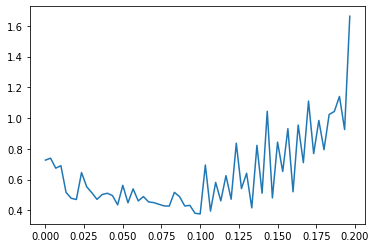

In [224]:
plt.plot(lrs, losses)
plt.show()

Pick the lower boundary as the value of the learning rate when the loss starts to decrease. Pick the upper learning rate when the loss slows, becomes ragged or increases. From this graph I would try $base\_lr=1e-5$ and $max\_lr=0.075$

In [225]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

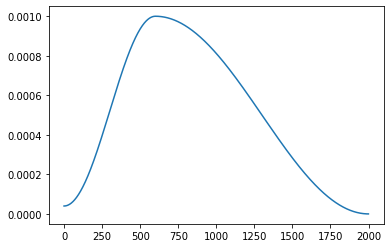

In [226]:
N = 2000
lr = get_cosine_triangular_lr(0.001, N)
plt.plot(list(range(N)), lr)
plt.show()

In [227]:
def train_triangular_policy(model, train_dl, valid_dl, max_lr=0.01, epochs=4):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x1, x2, y) in enumerate(train_dl):
            optim = get_optimizer(model, lr = lrs[idx], wd = 0.00001)
            batch = y.shape[0]
            y = y.unsqueeze(1)  
            out = model(x1, x2)
            loss = F.binary_cross_entropy_with_logits(out, y) 
            optim.zero_grad()
            loss.backward()
            optim.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
        print("train loss", sum_loss/total)
        val_loss(model, valid_dl)
    return sum_loss/total

In [228]:
# get a new model
model = MixedInputModel(emb_szs, 172)

In [229]:
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.08, epochs=10)

train loss 0.4420340150080456
val loss 0.348 and accuracy 0.854
train loss 0.3812336492737624
val loss 0.354 and accuracy 0.856
train loss 0.3949464450581895
val loss 0.324 and accuracy 0.872
train loss 0.40260836935898797
val loss 0.272 and accuracy 0.882
train loss 0.3751502594403194
val loss 0.279 and accuracy 0.888
train loss 0.3277132433184334
val loss 0.260 and accuracy 0.893
train loss 0.2839590787103946
val loss 0.251 and accuracy 0.897
train loss 0.25408555237896246
val loss 0.231 and accuracy 0.910
train loss 0.2409815379231964
val loss 0.228 and accuracy 0.910
train loss 0.23372027167340756
val loss 0.225 and accuracy 0.911


0.23372027167340756

## Lab

1. For the toy dataset, get a test score using the test dataset.
2. For the second model, get a better validation score by hyper-parameter tunning.
3. Find a tabular dataset and create your own model.